In [5]:
from __future__ import print_function

In [6]:
import os
import json

In [14]:
with open('./models/config.json', 'r') as f:
    config = json.load(f)
    
with open('./models/vocabulary/labels.txt', 'r') as f:
    vocab = {word: i for i, word in enumerate(f.readlines())}
    
serialization_dir = './models'
weights_file = './models/weights.th'

In [15]:
from text_field_embedder import TextFieldEmbedder
from feedforward import FeedForward
from similarity_function import SimilarityFunction
from elmo_token_embedder import ElmoTokenEmbedder

In [16]:
params = config.pop('model')
model_type = params.pop('type')
initializers = params.pop('initializer')

In [17]:
embedder_params = params.pop('text_field_embedder')
token_embedders = {}
for key, params2 in embedder_params.items():
    token_embedders[key] = ElmoTokenEmbedder(**params2)
text_field_embedder = TextFieldEmbedder(token_embedders)

In [18]:
attend_ff_params = params.pop('attend_feedforward')
attend_feedforward = FeedForward(**attend_ff_params)

In [19]:
similarity_func_params = params.pop('similarity_function')
similarity_function = SimilarityFunction()

In [20]:
compare_ff_params = params.pop('compare_feedforward')
compare_feedforward = FeedForward(**compare_ff_params)

In [21]:
aggregate_ff_params = params.pop('aggregate_feedforward')
aggregate_feedforward = FeedForward(**aggregate_ff_params)

In [22]:
from model import DecomposableAttention

In [23]:
model = DecomposableAttention(vocab, text_field_embedder, attend_feedforward,
                              similarity_function, compare_feedforward,
                              aggregate_feedforward)
model.load(serialization_dir, weights_file)

In [24]:
import spacy
nlp = spacy.load('en')

In [25]:
def tokenize(text):
    doc = nlp(text)
    return [token for token in doc]

In [26]:
p = 'If you help the needy, God will reward you.'
h = 'Giving money to the poor has good consequences.'

In [27]:
from elmo_indexer import ELMoTokenCharactersIndexer

In [28]:
indexer = ELMoTokenCharactersIndexer()

In [29]:
p_tokens = tokenize(unicode(p))
h_tokens = tokenize(unicode(h))

In [30]:
import torch
from torch.autograd import Variable

In [31]:
p_array = [indexer.token_to_indices(t, None) for t in p_tokens]
h_array = [indexer.token_to_indices(t, None) for t in h_tokens]

In [35]:
premise = {'elmo': Variable(torch.Tensor([p_array]).type(torch.LongTensor))}
hypothesis = {'elmo': Variable(torch.Tensor([h_array]).type(torch.LongTensor))}

In [36]:
outputs = model.forward(premise, hypothesis)

In [43]:
preds = 100 * np.squeeze(outputs['label_probs'].data.numpy())
attn = outputs['p2h_attention'].data.numpy()

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [45]:
print('{}\n\n{}'.format(p, h))

If you help the needy, God will reward you.

Giving money to the poor has good consequences.


In [46]:
print('Agree: {:.2f}% \nDisagree: {:.2f}% \nUnrelated: {:.2f}%'.
      format(preds[0], preds[1], preds[2]))

Agree: 71.93% 
Disagree: 8.89% 
Unrelated: 19.17%


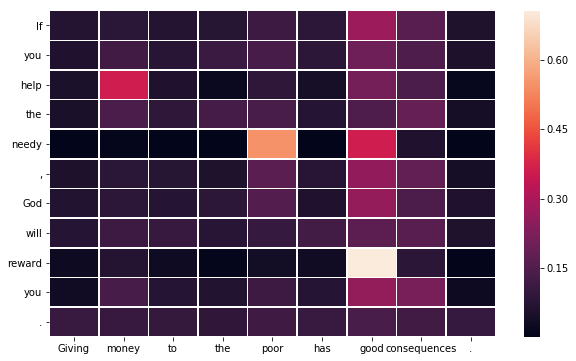

In [47]:
ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(np.squeeze(attn), linewidth=0.5)
ax.set_xticklabels(h_tokens)
ax.set_yticklabels(p_tokens, rotation='horizontal')
plt.show()